### Exercise 2

Consider the following setting: The input space is $\mathcal{X} = [0, 1]$ and the output space is $\mathcal{Y} = \{0, 1\}$. The input data $x \in \mathcal{X}$ is uniformly distributed. The Bayes classifier

$$
f^*(x)=\begin{cases}
1 & x \in [0.25, 0.75]\\
0 & \text{otherwise}
\end{cases}.
$$

has zero Bayes risk $R^*=R(f^*) = 0$. The hypothesis class 

$$
\mathcal{H} = \big\{f_{\theta}\,:\, \theta\in [0, 1]\big\}
$$

consists of threshold classifiers of the form

$$
f_{\theta}(x) = \begin{cases}
0 & x < \theta\\
1 & x \geq \theta
\end{cases}.
$$

**(a)** What is the true risk $R(f_{\mathcal{H}})$ of the best classifier from $\mathcal{H}$?

**(b)** For a given training set $\mathcal{S} = \Big((x_1, y_1),\ldots, (x_n, y_n)\Big)$, a learner $A$ returns a model $f_n = A(\mathcal{S}) \in \mathcal{H}$. 

Implement two learners: 

1. The first learner returns a hypothesis $f_n\in \mathcal{H}$ that minimizes the empirical risk on $\mathcal{S}$. 

2. The second learner randomly picks an input example $x_i$ from the training set and returns the hypothesis $f_n\in \mathcal{H}$ with threshold $\theta = x_i$.

**(c)** Consider the following experiment for a given learner $A$: 

1. Sample a training set $\mathcal{S}$ of size $n$. 
2. Fit a model $f_n$
3. Compute the empirical risk $R_n(f_n)$
4. Compute the true risk $R(f_n)$

Repeat the experiment $T$ times for different sizes $n$ and for both learners from (b). 

**(d)** Choose $\varepsilon = 0.1$ as error tolerance. Use the results from (c) to estimate the following probabilities for each size $n$ and for both learners from (b):

$$
\begin{align*}
\mathbb{P}(|R_n(f_n) - R(f_n)|\geq \varepsilon)\\
\mathbb{P}(|R_n(f_n) - R(f_{\mathcal{H}})|\geq \varepsilon)\\
\mathbb{P}(|R_n(f_n) - R(f^*)|\geq \varepsilon)
\end{align*}
$$

Plot the estimated probabilities together with Hoeffding's bound as a function of $n$. Discuss the results.

**(e)** Choose $\varepsilon = 0.1$ as error tolerance. Use the results from (c) to estimate the following probabilities for each size $n$ and for both learners from (b):

$$
\begin{align*}
\mathbb{P}(|R_n(f_n) - R(f_n)|\geq \varepsilon)\\
\mathbb{P}(|R(f_n) - R(f_{\mathcal{H}})|\geq \varepsilon)\\
\mathbb{P}(|R(f_n) - R(f^*)|\geq \varepsilon)
\end{align*}
$$

Plot the estimated probabilities as a function of $n$. Discuss the results.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

### Constants

In [6]:
# Interval of positive class
LOWER = 0.25
UPPER = 0.75

# Bayes Risk
B_RISK = 0.00

# Risk of f_H
H_RISK = 0.25

### Sampling

In [7]:
def sample(n):
    X = np.random.random(n)
    y = ((LOWER <= X) & (X <= UPPER)).astype(int)
    return X, y

### Classifiers

In [8]:
class ThresholdClassifier:
    
    def true_risk(self):
        if self.theta < LOWER:
            return (LOWER - self.theta) + (1. - UPPER)
        elif self.theta <= UPPER:
            return (self.theta - LOWER) + (1. - UPPER)
        else:
            return (UPPER - LOWER) + (1. - self.theta)
        
    def empirical_risk(self, X, y):
        y_pred = (X >= self.theta).astype(int)
        return 1. - accuracy_score(y, y_pred)


class ERMThresholdClassifier(ThresholdClassifier):
    def fit(self, X, y):
        self.theta = 1
        Z = X[y==1]
        if len(Z):
            self.theta = Z.min()

class RandomThresholdClassifier(ThresholdClassifier):
    def fit(self, X, y):
        i0 = np.random.randint(0, len(y))
        self.theta = X[i0]

---
### Auxiliary Functions

In [9]:
def run(f, n_samples, n_runs=100):
    k = len(n_samples)
    R = np.zeros((k, n_runs))
    Rn = np.zeros((k, n_runs))
    for i, n in enumerate(n_samples):
        for j in range(n_runs):
            X, y = sample(n)
            f.fit(X, y)
            Rn[i,j] = f.empirical_risk(X, y)
            R[i,j] = f.true_risk()
    return Rn, R

def compute_probs(n_samples, Rn, R, eps=0.1):
    k = len(n_samples)
    Pn = np.zeros((3, k))
    P = np.zeros((3, k))
    for i in range(k):
        Pn[0,i] = np.mean(np.abs(Rn[i]-R[i]) >= eps)
        Pn[1,i] = np.mean(np.abs(Rn[i]-H_RISK) >= eps)
        Pn[2,i] = np.mean(np.abs(Rn[i]-B_RISK) >= eps)
        P[0,i] = np.mean(np.abs(Rn[i]-R[i]) >= eps)
        P[1,i] = np.mean(np.abs(R[i]-H_RISK) >= eps)
        P[2,i] = np.mean(np.abs(R[i]-B_RISK) >= eps) 
    return Pn, P

def plot(n_samples, Pn, P, eps=0.1):
    
    # Hoeffding's bound
    H = 2.*np.exp(-2.*n_samples*eps**2)

    _, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
    
    ax[0].plot(n_samples, Pn[0], lw=2, 
               label='$P(|R_n(f_n)-R(f_n)|\geq \epsilon)$')
    ax[0].plot(n_samples, Pn[1], lw=2, 
               label='$P(|R_n(f_n)-R(f_H)|\geq \epsilon)$')
    ax[0].plot(n_samples, Pn[2], lw=2, 
               label='$P(|R_n(f_n)-R(f^*)|\geq \epsilon)$')
    ax[0].plot(n_samples, H, lw=2, 
               label='Hoeffding')
    ax[0].set_xlabe=('n')
    ax[0].legend()

    ax[1].plot(n_samples, P[0], lw=2, 
               label='$P(|R_n(f_n)-R(f_n)|\geq \epsilon)$')
    ax[1].plot(n_samples, P[1], lw=2, 
               label='$P(|R(f_n)-R(f_H)|\geq \epsilon)$')
    ax[1].plot(n_samples, P[2], lw=2, 
               label='$P(|R(f_n)-R(f^*)|\geq \epsilon)$')
    ax[1].set_xlabe=('n')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

def experiment(f, n_samples, n_runs, eps):
    Rn, R = run(f, n_samples=n_samples, n_runs=n_runs)
    Pn, P = compute_probs(n_samples, Rn, R, eps=eps)
    plot(n_samples, Pn, P)

### Experimental Setup

In [17]:
n_samples=np.arange(10, 301, 10)
n_runs = 100
eps = 0.1

### ERM Threshold Classifier

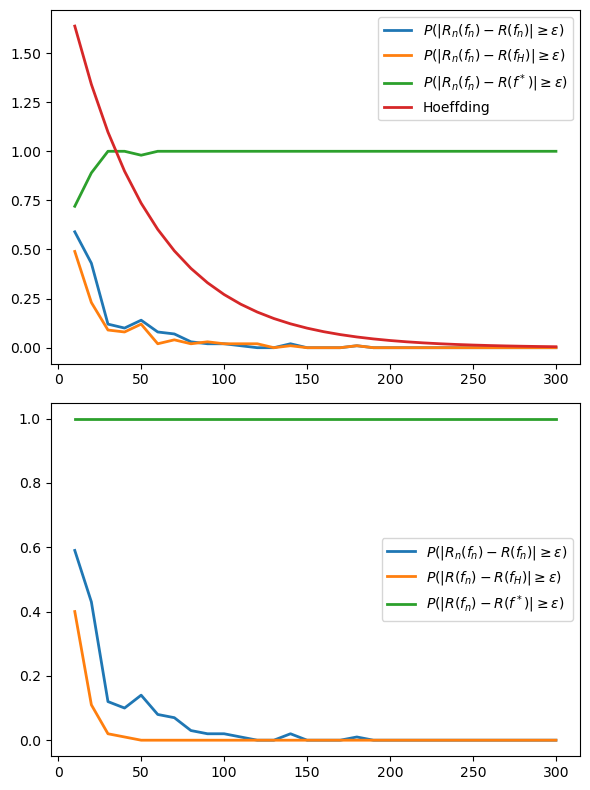

In [18]:
experiment(ERMThresholdClassifier(), n_samples, n_runs, eps)

### Random Threshold Classifier

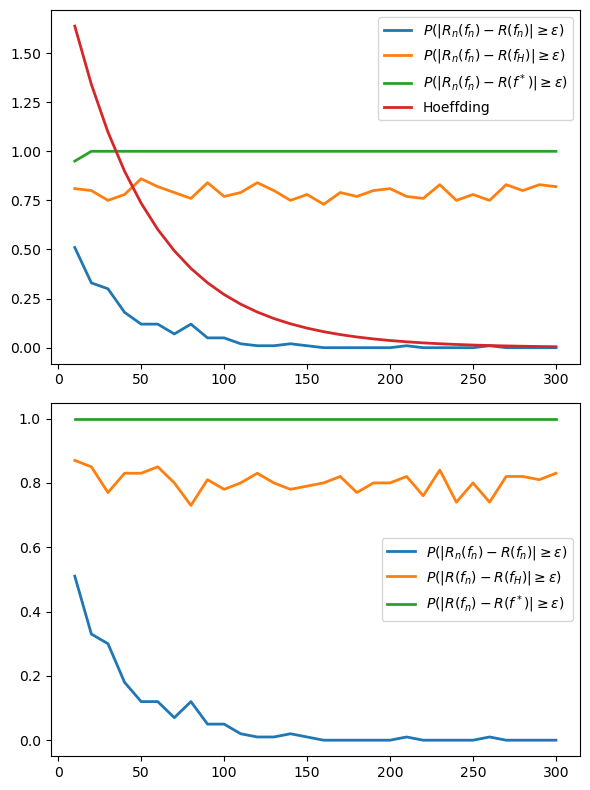

In [19]:
experiment(RandomThresholdClassifier(), n_samples, n_runs, eps)

---
### Discussion

**1. Introduction:** We first consider the estimated probabilites from part (d):

$$
\begin{align*}
\mathbb{P}(|R_n(f_n) - R(f_n)|\geq \varepsilon)\\
\mathbb{P}(|R_n(f_n) - R(f_{\mathcal{H}})|\geq \varepsilon)\\
\mathbb{P}(|R_n(f_n) - R(f^*)|\geq \varepsilon)
\end{align*}
$$

The probabilities indicate the likelihood of the empirical risk $R_n(f_n)$ of the model $f_n$​ deviating from the true risks $R(f_n)$, $R(f_{\mathcal{H}})$, and $R(f^*)$ by more than our error tolerance $\varepsilon$. 

**Observations:**

+ As the sample size $n$ increases, the empirical risk $R_n(f_n)$ seems to converge in probability to the true risk $R(f_n)$ for both learners. 

+ If $f_n$ is trained by the ERM learner, $R_n(f_n)$ also appears to converge in probability to $R(f_{\mathcal{H}})$. 

+ Both learners are unable to achieve Bayes risk, due to the limited hypothesis class.

**Discussion:**
It is important to note that the model $f_n$ is not fixed but depends on the sample $\mathcal{S}_n$. Therfore, these observations are not due to pointwise consistency. In case of the ERM learner and apparently follow another principle.

To get an intuition, consider Hoeffding's inequality with error tolerance $\varepsilon = 0.1$. The estimated probability $\mathbb{P}(|R_n(f_n) - R(f_n)|\geq \varepsilon)$ obeys the Hoeffding bound with the ERM learner but violates it with the random learner. However, Hoeffding's inequality is violated in both cases and is not applicable (see lecture 4, slide 34). To verify this, repeat the experiments with a smaller $\varepsilon$, such as $\varepsilon = 0.01$

**Remark:** The probability $\mathbb{P}(|R_n(f_n) - R(f_n)|\geq \varepsilon)$ can be worse than $\mathbb{P}(|R_n(f_n) - R(f_{\mathcal{H}})|\geq \varepsilon)$ due to overfitting. Specifically, for small $n$, we have

$$
R_n(f_n) \leq R(f_{\mathcal{H}}) \leq R(f_n)
$$
    
The first inequality arises from overfitting, the second inequality is based on the assumption that $f_{\mathcal{H}}$ is the optimal hypothesis within $\mathcal{H}$.

**2. Introduction** Next, we consider the estimated probabilites of part (e):
$$
\begin{align*}
\mathbb{P}(|R_n(f_n) - R(f_n)|\geq \varepsilon)\\
\mathbb{P}(|R(f_n) - R(f_{\mathcal{H}})|\geq \varepsilon)\\
\mathbb{P}(|R(f_n) - R(f^*)|\geq \varepsilon)
\end{align*}
$$

The first probability has been discussed in (d). The second and third probabilities capture the estimation error $|R(f_n) - R(f_{\mathcal{H}})|$ and  the deviation $|R(f_n) - R(f^*)|$ from the Bayes risk, respectively.

**Observations:**

+ The ERM learner’s estimation error probability appears to converge to zero.

+ The random learner’s estimation error probability remains large. 

+ Both learners show a large probability of deviating from the Bayes risk.


**Discussion:**
The results suggest that the ERM learner, as n approaches infinity, can achieve the optimal risk $R(f_{\mathcal{H}})$ in probability, indicating effective estimation error minimization. Conversely, the random learner fails to converge to $R(f_{\mathcal{H}})$, suggesting limitations in its approach to hypothesis selection. 